In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score

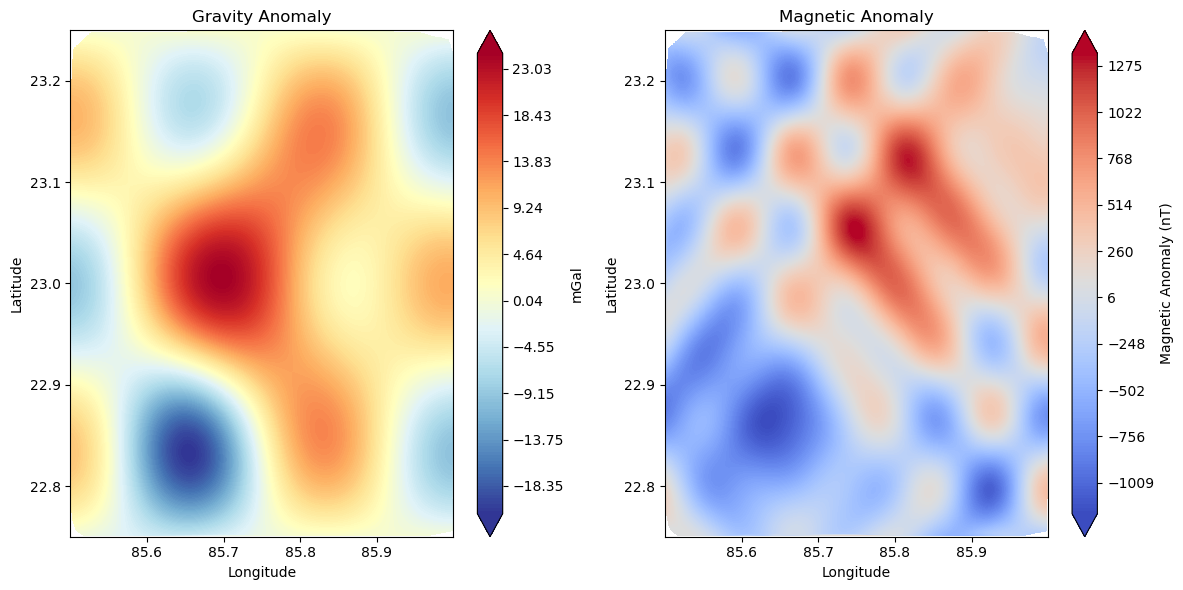

In [3]:
from scipy.interpolate import griddata
data = pd.read_csv("synthetic_file.csv")
# Define grid extent
lon_min, lon_max = data['Longitude'].min(), data['Longitude'].max()
lat_min, lat_max = data['Latitude'].min(), data['Latitude'].max()

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[lon_min:lon_max:600j, lat_min:lat_max:600j]

# Interpolate gravity anomaly
gravity_grid = griddata((data['Longitude'], data['Latitude']), data['Gravity_Anomaly'], (grid_x, grid_y), method='cubic')

# Interpolate magnetic anomaly
magnetic_grid = griddata((data['Longitude'], data['Latitude']), data['Magnetic_Anomaly'], (grid_x, grid_y), method='cubic')


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gravity anomaly plot
contour1 = axes[0].contourf(grid_x, grid_y, gravity_grid, levels=np.linspace(data['Gravity_Anomaly'].min(), data['Gravity_Anomaly'].max(), 150), cmap='RdYlBu_r', extend='both')
fig.colorbar(contour1, ax=axes[0], label='mGal')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Gravity Anomaly')
axes[0].set_xlim(lon_min, lon_max)
axes[0].set_ylim(lat_min, lat_max)

# Magnetic anomaly plot
contour2 = axes[1].contourf(grid_x, grid_y, magnetic_grid, levels=np.linspace(data['Magnetic_Anomaly'].min(), data['Magnetic_Anomaly'].max(), 150), cmap='coolwarm', extend='both')
fig.colorbar(contour2, ax=axes[1], label='Magnetic Anomaly (nT)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Magnetic Anomaly')
axes[1].set_xlim(lon_min, lon_max)
axes[1].set_ylim(lat_min, lat_max)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

    grid_size  sigma  learning_rate  iterations  silhouette_score  \
26     (5, 5)    1.0            0.4        8000          0.355672   
2      (5, 5)    0.5            0.1        8000          0.352403   
102    (6, 6)    0.5            0.3        8000          0.352272   
10     (5, 5)    0.5            0.4        8000          0.349409   
3      (5, 5)    0.5            0.1       10000          0.347577   
198    (7, 7)    0.5            0.3        8000          0.346437   
298    (8, 8)    0.5            0.4        8000          0.346374   
398  (10, 10)    0.5            0.5        8000          0.346239   
15     (5, 5)    0.5            0.5       10000          0.345775   
111    (6, 6)    0.5            0.5       10000          0.345396   

     quantization_error  topographic_error  num_clusters  
26             0.049816           0.792000            25  
2              0.049649           0.848000            25  
102            0.040987           0.839333            36  
10  

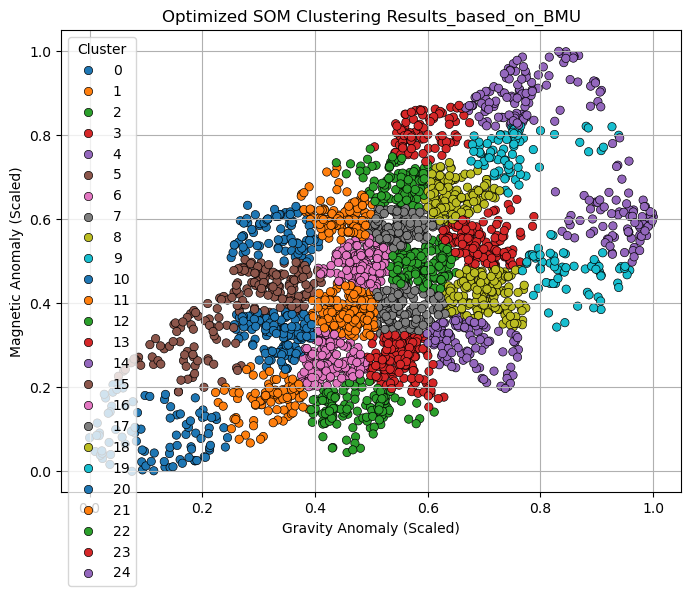

In [5]:
# Load dataset
data = pd.read_csv("synthetic_file.csv")

# Select features
features = ["Gravity_Anomaly", "Magnetic_Anomaly"]
X = data[features].values

# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------- Define Parameter Ranges ----------------------
sigma_values = [0.5, 1.0, 1.5, 2.0,2.5,3.0]
learning_rates = [0.1, 0.3,0.4, 0.5]
iterations_list = [ 1000, 2000,8000,10000]
grid_sizes = [(5, 5), (6, 6), (7, 7),(8,8),(10,10)]  # SOM grid dimensions

# ----------------------  Optimization Function ----------------------
def train_som(grid_size, sigma, learning_rate, iterations):
    """Train SOM with given parameters and compute evaluation metrics."""
    som = MiniSom(grid_size[0], grid_size[1], X_scaled.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(X_scaled)
    som.train_random(X_scaled, iterations)

    # Assign clusters based on Best Matching Units (BMUs)
    labels = np.array([som.winner(x) for x in X_scaled])
    unique_labels, encoded_labels = np.unique(labels, axis=0, return_inverse=True)

    # Compute Metrics
    quantization_error = som.quantization_error(X_scaled)
    topographic_error = sum(1 for x in X_scaled if len(set(som.winner(x))) > 1) / len(X_scaled)

    # Compute silhouette score (only if more than 1 cluster)
    num_clusters = len(np.unique(encoded_labels))
    silhouette = silhouette_score(X_scaled, encoded_labels) if num_clusters > 1 else -1

    return silhouette, quantization_error, topographic_error, num_clusters

# ---------------------- Hyperparameter Search ----------------------
best_params = None
best_score = -1 
results = []

# Grid search through all parameter combinations
for grid_size, sigma, learning_rate, iterations in itertools.product(grid_sizes, sigma_values, learning_rates, iterations_list):
    silhouette, q_error, t_error, n_clusters = train_som(grid_size, sigma, learning_rate, iterations)
    
    results.append({
        "grid_size": grid_size,
        "sigma": sigma,
        "learning_rate": learning_rate,
        "iterations": iterations,
        "silhouette_score": silhouette,
        "quantization_error": q_error,
        "topographic_error": t_error,
        "num_clusters": n_clusters
    })

    # Update best parameters if silhouette score improves
    if silhouette > best_score:
        best_score = silhouette
        best_params = (grid_size, sigma, learning_rate, iterations)

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="silhouette_score", ascending=False).head(10))  # Show top 10 results

# ----------------------  Best SOM Model Training ----------------------
best_grid, best_sigma, best_lr, best_iters = best_params
print(f" Best Parameters: Grid={best_grid}, Sigma={best_sigma}, LR={best_lr}, Iterations={best_iters}")

# Train SOM with best parameters
som = MiniSom(best_grid[0], best_grid[1], X_scaled.shape[1], sigma=best_sigma, learning_rate=best_lr)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, best_iters)

# Assign clusters
labels = np.array([som.winner(x) for x in X_scaled])
unique_labels, encoded_labels = np.unique(labels, axis=0, return_inverse=True)
data["Cluster_Label"] = encoded_labels

# ---------------------- Visualize Clusters ----------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=encoded_labels, palette="tab10", edgecolor="k")
plt.xlabel("Gravity Anomaly (Scaled)")
plt.ylabel("Magnetic Anomaly (Scaled)")
plt.title("Optimized SOM Clustering Results_based_on_BMU")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Testing: Grid=(5, 5), Sigma=0.5, LR=0.1, Iterations=1000
✅ Found Best Config: ((5, 5), 0.5, 0.1, 1000) with Silhouette Score: 0.2951741445526638
Testing: Grid=(5, 5), Sigma=0.5, LR=0.1, Iterations=2000
✅ Found Best Config: ((5, 5), 0.5, 0.1, 2000) with Silhouette Score: 0.3395062483189758
Testing: Grid=(5, 5), Sigma=0.5, LR=0.1, Iterations=8000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.1, Iterations=10000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.3, Iterations=1000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.3, Iterations=2000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.3, Iterations=8000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.3, Iterations=10000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.4, Iterations=1000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.4, Iterations=2000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.4, Iterations=8000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.4, Iterations=10000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.5, Iterations=1000
Testing: Grid=(5, 5), Sigma=0.5, LR=0.5, Iterations=2000
Testing: Grid=(5, 5), S

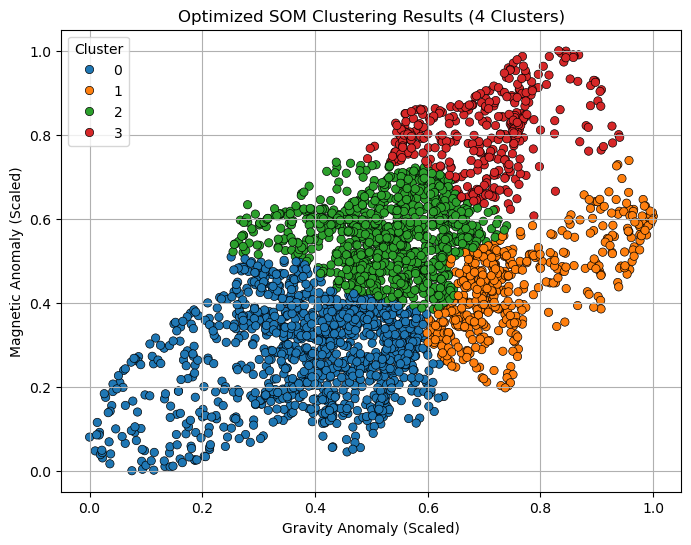

In [7]:
from sklearn.cluster import KMeans

# Load data
data = pd.read_csv("SHAMILCK_AIRBORNE_FINAL(t).csv")

# Select features
features = ["Gravity_Anomaly", "Magnetic_Anomaly"]
X = data[features].values

# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define Hyperparameter Search Space
sigma_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
learning_rates = [0.1, 0.3, 0.4, 0.5]
iterations_list = [1000, 2000, 8000, 10000]
grid_sizes = [(5, 5), (6, 6), (7, 7), (8, 8), (10, 10)]

# Set Random Seed for Stability
np.random.seed(42)

def train_som(grid_size, sigma, learning_rate, iterations):
    """Train SOM and apply K-Means to force 4 clusters."""
    som = MiniSom(grid_size[0], grid_size[1], X_scaled.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(X_scaled)
    som.train_random(X_scaled, iterations)

    # Extract SOM neuron weights
    som_weights = np.array([som.get_weights()[i][j] for i in range(grid_size[0]) for j in range(grid_size[1])])

    # Apply K-Means to ensure exactly 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans.fit(som_weights)

    # Assign each data point to the nearest cluster
    bmu_indices = np.array([som.winner(x) for x in X_scaled])
    bmu_flattened = [i * grid_size[1] + j for i, j in bmu_indices]
    cluster_labels = kmeans.labels_[bmu_flattened]

    # Compute Metrics
    quantization_error = som.quantization_error(X_scaled)
    silhouette = silhouette_score(X_scaled, cluster_labels)

    return silhouette, quantization_error, cluster_labels

# Hyperparameter Search
best_params = None
best_score = -1
results = []

for grid_size, sigma, learning_rate, iterations in itertools.product(grid_sizes, sigma_values, learning_rates, iterations_list):
    print(f"Testing: Grid={grid_size}, Sigma={sigma}, LR={learning_rate}, Iterations={iterations}")
    
    silhouette, q_error, cluster_labels = train_som(grid_size, sigma, learning_rate, iterations)

    results.append({
        "grid_size": grid_size,
        "sigma": sigma,
        "learning_rate": learning_rate,
        "iterations": iterations,
        "silhouette_score": silhouette,
        "quantization_error": q_error,
    })

    if silhouette > best_score:
        best_score = silhouette
        best_params = (grid_size, sigma, learning_rate, iterations)
        best_clusters = cluster_labels  # Store the best clustering labels
        print(f" Found Best Config: {best_params} with Silhouette Score: {best_score}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Train SOM with Best Parameters
if best_params:
    best_grid, best_sigma, best_lr, best_iters = best_params
    print(f" Using Best Parameters: Grid={best_grid}, Sigma={best_sigma}, LR={best_lr}, Iterations={best_iters}")
    data["Cluster_Label"] = best_clusters

    # Visualize Clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=best_clusters, palette="tab10", edgecolor="k")
    plt.xlabel("Gravity Anomaly (Scaled)")
    plt.ylabel("Magnetic Anomaly (Scaled)")
    plt.title("Optimized SOM Clustering Results (4 Clusters)")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()
else:
    print(" No valid parameter combination found.")


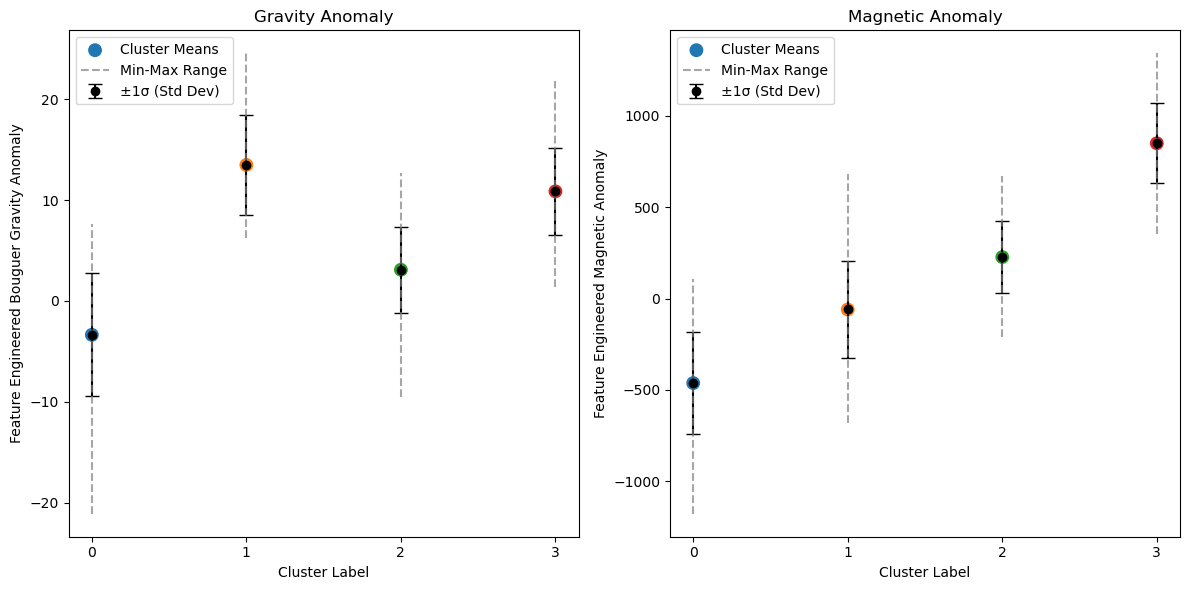

In [9]:
data["Cluster_Label"] = best_clusters  # Assign computed cluster labels

# ---------------------- Compute Cluster Statistics ---------------------
def compute_cluster_stats(data, feature):
    """Calculate mean, std, min, and max for each cluster."""
    stats_df = data.groupby("Cluster_Label")[feature].agg(
        mean_value="mean",
        std_value="std",
        min_value="min",
        max_value="max"
    ).reset_index()
    return stats_df

# Compute stats for gravity and magnetic anomalies
cluster_stats_gravity = compute_cluster_stats(data, "Gravity_Anomaly")
cluster_stats_magnetic = compute_cluster_stats(data, "Magnetic_Anomaly")

# Define colors based on clusters
num_clusters = len(np.unique(best_clusters))
colors = sns.color_palette("tab10", num_clusters)

# ----------------------  Create Statistical Plots ---------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Gravity Plot ---
axes[0].scatter(cluster_stats_gravity["Cluster_Label"], cluster_stats_gravity["mean_value"], 
                c=[colors[i] for i in cluster_stats_gravity["Cluster_Label"]], s=80, label="Cluster Means")
axes[0].errorbar(cluster_stats_gravity["Cluster_Label"], cluster_stats_gravity["mean_value"],
                 yerr=cluster_stats_gravity["std_value"], fmt="o", color="black", ecolor="black", capsize=5, label="±1σ (Std Dev)")
for i, row in cluster_stats_gravity.iterrows():
    axes[0].plot([row["Cluster_Label"], row["Cluster_Label"]], [row["min_value"], row["max_value"]],
                 "--", color="gray", alpha=0.7, label="Min-Max Range" if i == 0 else "")
axes[0].set_xticks(cluster_stats_gravity["Cluster_Label"])
axes[0].set_xlabel("Cluster Label")
axes[0].set_ylabel("Feature Engineered Bouguer Gravity Anomaly")
axes[0].set_title("Gravity Anomaly")
axes[0].legend()

# --- Magnetic Plot ---
axes[1].scatter(cluster_stats_magnetic["Cluster_Label"], cluster_stats_magnetic["mean_value"], 
                c=[colors[i] for i in cluster_stats_magnetic["Cluster_Label"]], s=80, label="Cluster Means")
axes[1].errorbar(cluster_stats_magnetic["Cluster_Label"], cluster_stats_magnetic["mean_value"],
                 yerr=cluster_stats_magnetic["std_value"], fmt="o", color="black", ecolor="black", capsize=5, label="±1σ (Std Dev)")
for i, row in cluster_stats_magnetic.iterrows():
    axes[1].plot([row["Cluster_Label"], row["Cluster_Label"]], [row["min_value"], row["max_value"]],
                 "--", color="gray", alpha=0.7, label="Min-Max Range" if i == 0 else "")
axes[1].set_xticks(cluster_stats_magnetic["Cluster_Label"])
axes[1].set_xlabel("Cluster Label")
axes[1].set_ylabel("Feature Engineered Magnetic Anomaly")
axes[1].set_title("Magnetic Anomaly")
axes[1].legend()

plt.tight_layout()
plt.show()


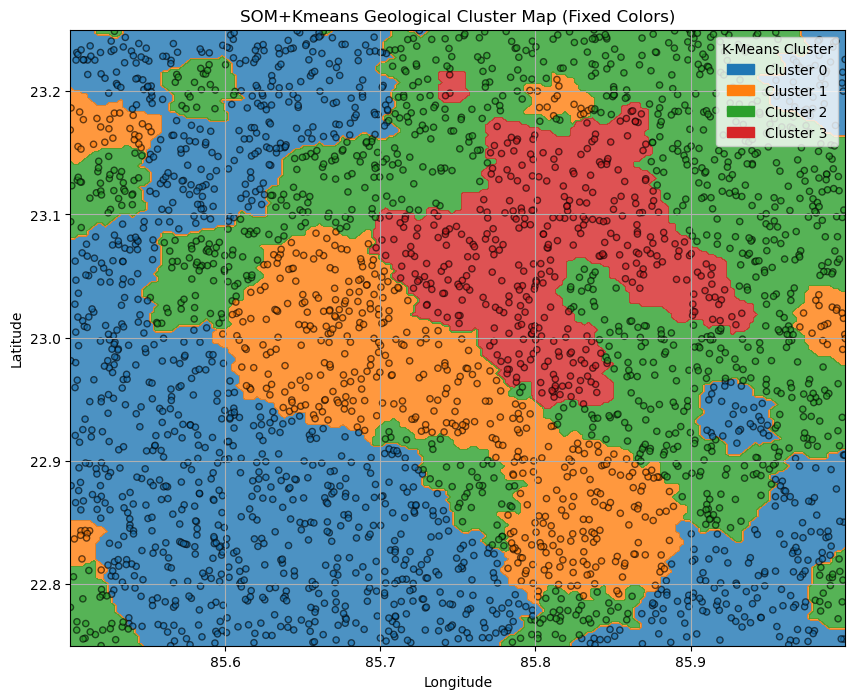

In [33]:
#interpolation for visualising in lat lon
if not {"Latitude", "Longitude", "Cluster_Label"}.issubset(data.columns):
    raise ValueError(" Data must contain 'Latitude', 'Longitude', and 'Cluster_Label'!")

# Define a fixed color palette for clusters (must match previous plots)
num_clusters = len(np.unique(best_clusters))
colors = {i: c for i, c in enumerate(sns.color_palette("tab10", num_clusters))}

# ----------------------  Generate Grid for Interpolation ---------------------
# Create a mesh grid for spatial interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(data["Longitude"].min(), data["Longitude"].max(), 200),
    np.linspace(data["Latitude"].min(), data["Latitude"].max(), 200)
)

# Interpolate cluster labels to generate a smooth boundary
grid_cluster = griddata(
    (data["Longitude"], data["Latitude"]),  # Known points
    data["Cluster_Label"],                  # Cluster labels
    (grid_x, grid_y),                        # Grid for interpolation
    method="nearest"                          # Nearest neighbor interpolation
)

# ---------------------- Plot the Spatial Cluster Map ---------------------
fig, ax = plt.subplots(figsize=(10, 8))

# Create a filled contour plot (color-coded regions)
contour = ax.contourf(grid_x, grid_y, grid_cluster, levels=np.arange(-0.5, num_clusters, 1),
                      colors=[colors[i] for i in range(num_clusters)], alpha=0.8)

# Overlay scatter points to show actual data locations
scatter = ax.scatter(data["Longitude"], data["Latitude"], c=data["Cluster_Label"].map(colors),
                     edgecolor="black", s=20, alpha=0.6)

# Improve readability
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("SOM+Kmeans Geological Cluster Map (Fixed Colors)")
ax.grid(True)

# Create a legend manually
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(num_clusters)]
ax.legend(handles, [f"Cluster {i}" for i in range(num_clusters)], title="K-Means Cluster", loc="upper right")

# Show the plot
plt.show()


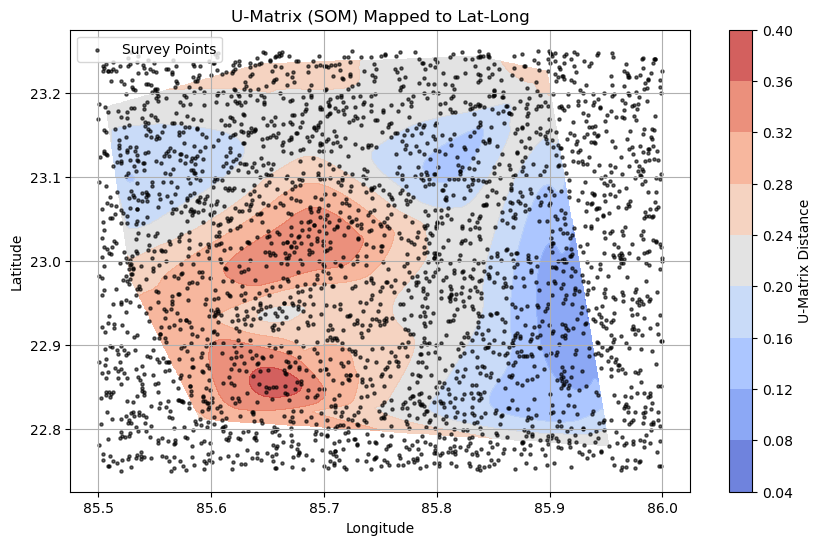

In [31]:
#u matrix visualisation

from minisom import MiniSom

# ----------------------  Train Self-Organizing Map (SOM) ---------------------
som_size = (5,5)  # Adjust SOM grid size

# Initialize and train SOM
som = MiniSom(som_size[0], som_size[1], X_scaled.shape[1], sigma=0.5, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 10000)  # Train with 8000 iterations

# ---------------------- 🔍 Compute U-Matrix ---------------------
def compute_u_matrix(som):
    """Computes the U-Matrix for a trained SOM."""
    weights = som.get_weights()
    umatrix = np.zeros((som_size[0], som_size[1]))

    for i in range(som_size[0]):
        for j in range(som_size[1]):
            neighbors = []
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Neighbor directions
                ni, nj = i + di, j + dj
                if 0 <= ni < som_size[0] and 0 <= nj < som_size[1]:  # Valid neighbor
                    neighbors.append(weights[ni, nj])
            umatrix[i, j] = np.mean([np.linalg.norm(weights[i, j] - n) for n in neighbors])

    return umatrix

# Compute U-Matrix
u_matrix = compute_u_matrix(som)

# ---------------------- 📍 Map U-Matrix to Lat-Long ---------------------
# Find BMU (Best Matching Unit) for each data point
bmu_coords = np.array([som.winner(x) for x in X_scaled])

# Extract unique BMU positions & assign corresponding lat-long
unique_bmus, indices = np.unique(bmu_coords, axis=0, return_index=True)
bmu_latitudes = data["Latitude"].values[indices]
bmu_longitudes = data["Longitude"].values[indices]

# ---------------------- 🌍 Interpolate for Continuous U-Matrix Map ---------------------
grid_x, grid_y = np.mgrid[
    bmu_longitudes.min():bmu_longitudes.max():500j, 
    bmu_latitudes.min():bmu_latitudes.max():500j
]

u_matrix_grid = griddata(
    (bmu_longitudes, bmu_latitudes), u_matrix.flatten(), (grid_x, grid_y), method="cubic"
)

# ---------------------- 📊 Plot U-Matrix on Geographical Map ---------------------
plt.figure(figsize=(10, 6))
plt.contourf(grid_x, grid_y, u_matrix_grid, cmap="coolwarm", alpha=0.8)
plt.colorbar(label="U-Matrix Distance")  # Color scale shows distance values

# Plot actual data points
plt.scatter(data["Longitude"], data["Latitude"], c='black', s=5, label="Survey Points", alpha=0.6)

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("U-Matrix (SOM) Mapped to Lat-Long")
plt.legend()
plt.grid(True)

plt.show()